In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import math

from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

from lmfit import Model
from sklearn.metrics import pairwise_distances_argmin_min

from scipy.optimize import curve_fit
plt.rcParams['text.usetex'] = False

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import make_interp_spline, BSpline


In [26]:
directory = "/Users/satoshisimental/Desktop/INNN_calib/INNN_calibration/peliculas01"
image_paths = []
image_rgb_values = []
colors_std_list = []
rad_list = [0, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]


def detect_squares(image_path, scale_factor=0.5):
    """detect_squares toma como parametros la direccion de una imagen y un factor de
    escalado la funcion lleva a cabo la detección de recuadros y calcula la respuesta
    en los canales rgb de la imagen"""

    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    strip_list = []
    std_list = []

    if image is None:
        raise ValueError(f"Image not found at {image_path}")

    if image.dtype != np.uint16:
        raise ValueError(f"Image at {image_path} is not a 16-bit image")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    color_threshold = 180 #This value determines how low the activation of color must be to be considered a square.
    
    _, thresh = cv2.threshold(gray, color_threshold * 256, 65535, cv2.THRESH_BINARY_INV)

    # We need to convert image to 8bit to draw contours
    thresh_8bit = cv2.convertScaleAbs(thresh, alpha=(255.0 / 65535.0))

    contours, _ = cv2.findContours(thresh_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    output_image = image.copy()

    for contour in contours:
        one_square_color = []

        epsilon = 0.1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Checking if the shape is a square and scalling the area of interest to extract color
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            side_length = min(w, h)
            center_x, center_y = x + w // 2, y + h // 2

            shrunken_side_length = int(side_length * scale_factor)
            shrunken_x = center_x - shrunken_side_length // 2
            shrunken_y = center_y - shrunken_side_length // 2

            shrunken_contour = np.array([
                [shrunken_x, shrunken_y],
                [shrunken_x + shrunken_side_length, shrunken_y],
                [shrunken_x + shrunken_side_length, shrunken_y + shrunken_side_length],
                [shrunken_x, shrunken_y + shrunken_side_length]
            ]).reshape((-1, 1, 2))

            cv2.drawContours(output_image, [shrunken_contour], 0, (0, 65535, 0), 1)

            #Extracting the RGB values of the desired area
            mask = np.zeros_like(gray, dtype=np.uint8)
            cv2.drawContours(mask, [shrunken_contour], -1, 255, -1)

            mean_color = cv2.mean(image, mask=mask)
            mean_color_rgb = (mean_color[2], mean_color[1], mean_color[0])

            one_square_color.append(mean_color[2])
            one_square_color.append(mean_color[1])
            one_square_color.append(mean_color[0])

            masked_pixels = cv2.bitwise_and(image, image, mask=mask)
            r_values = masked_pixels[:, :, 2][mask == 255]
            g_values = masked_pixels[:, :, 1][mask == 255]
            b_values = masked_pixels[:, :, 0][mask == 255]

            # Calculating the standard deviation of RGB values
            r_std = np.std(r_values)
            g_std = np.std(g_values)
            b_std = np.std(b_values)

            std_list.append([r_std, g_std, b_std])

        strip_list.append(one_square_color)

    image_8bit = cv2.convertScaleAbs(image, alpha=(255.0 / 65535.0))
    output_image_8bit = cv2.convertScaleAbs(output_image, alpha=(255.0 / 65535.0))

    # Remove comments to visualize the images and the contours used to extract RGB values
    """plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image_8bit, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title('Traced Silhouettes with Average Colors')
    plt.imshow(cv2.cvtColor(output_image_8bit, cv2.COLOR_BGR2RGB))
    plt.show()"""

    return strip_list, std_list

# Accessing folder that contains the RGB images and creating a list that contains mean RGB activation. Each channel separately
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        if pathlib.Path(f).suffix == ".tif":
            image_paths.append(f)
            list1, list2 = detect_squares(f)
            image_rgb_values.append(list1)
    
            for rgb_values, std_values in zip(list1, list2):
                colors_std_list.append({
                    'r': rgb_values[0],
                    'g': rgb_values[1],
                    'b': rgb_values[2],
                    'std_r': std_values[0],
                    'std_g': std_values[1],
                    'std_b': std_values[2]
                })

#print(colors_std_list)

Performing Kmeans on data for clustering

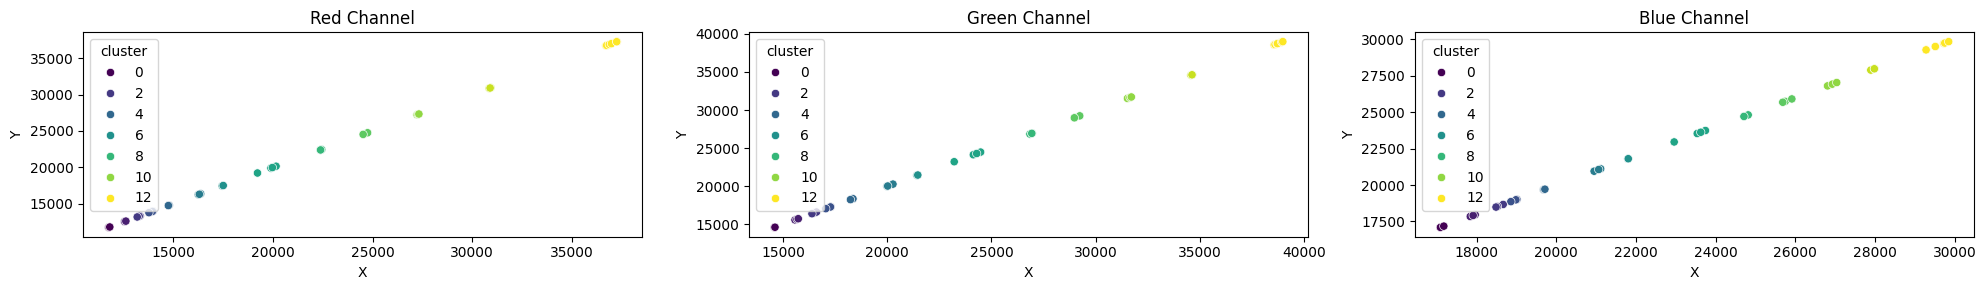

Number of outliers detected: 1
Number of non-outliers detected: 42


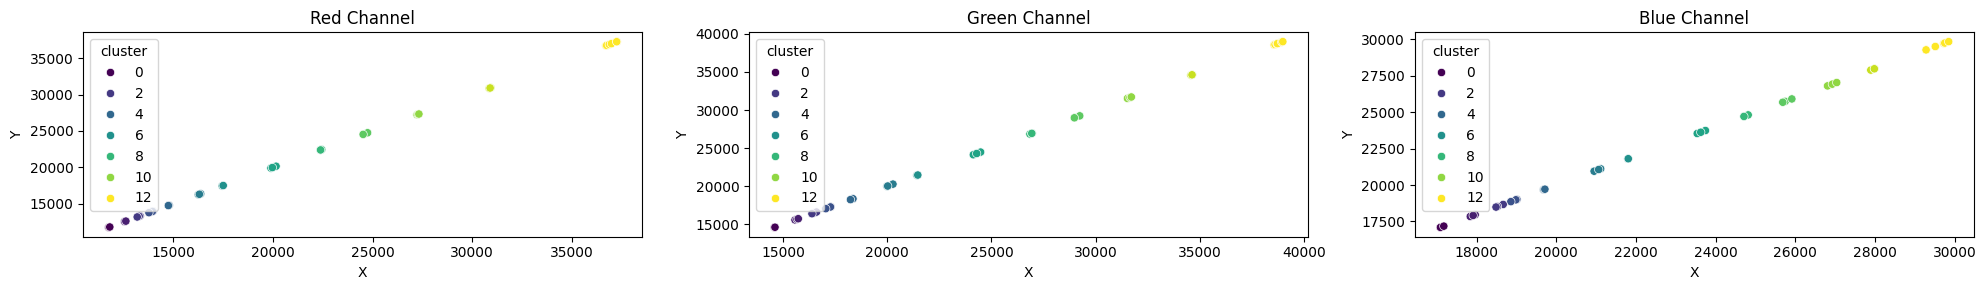

In [36]:
# We are performing two kmeans. The first one is to extract outliers and second one is to recalculate clusters without outliers
colors_std = pd.DataFrame(colors_std_list)

colors = colors_std[['r', 'g', 'b']].apply(np.log10) #applying a transformation for kmeans
colors_np = colors.to_numpy()
num_clusters = 13 #Number of clusters =  number of different doses 

kmeans = KMeans(n_clusters=num_clusters, random_state=8, n_init=10)
kmeans.fit(colors_np)

labels = kmeans.labels_
colors_std['cluster'] = labels

# Ordering the clusters. Highest activation, higher rank in cluster
cluster_means = colors_std.groupby('cluster')[['r', 'g', 'b']].mean()
cluster_means['mean_rgb'] = cluster_means.mean(axis=1)
sorted_clusters = cluster_means.sort_values('mean_rgb').index
cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
colors_std['cluster'] = colors_std['cluster'].map(cluster_mapping)

# Recalculate the cluster centers based on the new ordered labels
new_centers = np.zeros_like(kmeans.cluster_centers_)
for old_label, new_label in cluster_mapping.items():
    new_centers[new_label] = kmeans.cluster_centers_[old_label]

# Plot the ordered clusters with outliers
plt.figure(figsize=(20, 3))

plt.subplot(1, 3, 1)
sns.scatterplot(data=colors_std, x='r', y='r', hue='cluster', palette='viridis')
plt.title('Red Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 2)
sns.scatterplot(data=colors_std, x='g', y='g', hue='cluster', palette='viridis')
plt.title('Green Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 3)
sns.scatterplot(data=colors_std, x='b', y='b', hue='cluster', palette='viridis')
plt.title('Blue Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

# Calculate distances and detect outliers
max_std = 1.5 #define the max distance to be considered an outlier
distances = pairwise_distances_argmin_min(colors_np, new_centers)[1]
cluster_std = np.zeros(num_clusters)

for cluster in range(num_clusters):
    cluster_distances = distances[labels == cluster]
    cluster_std[cluster] = np.std(cluster_distances)

outliers = np.zeros(len(colors_np), dtype=bool)
for cluster in range(num_clusters):
    cluster_distances = distances[labels == cluster]
    threshold = np.mean(cluster_distances) + max_std * cluster_std[cluster]
    outliers[labels == cluster] = cluster_distances > threshold

non_outliers_std = colors_std[~outliers].reset_index(drop=True)
outliers_std = colors_std[outliers].reset_index(drop=True)

non_outlier_colors_np = non_outliers_std[['r', 'g', 'b']].apply(np.log10).to_numpy()

kmeans.fit(non_outlier_colors_np)
new_labels = kmeans.labels_

non_outliers_std['cluster'] = new_labels

# Ordering the new set of clusters w/out outliers
cluster_means_non_outliers = non_outliers_std.groupby('cluster')[['r', 'g', 'b']].mean()
cluster_means_non_outliers['mean_rgb'] = cluster_means_non_outliers.mean(axis=1)
sorted_clusters_non_outliers = cluster_means_non_outliers.sort_values('mean_rgb').index
cluster_mapping_non_outliers = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters_non_outliers)}
non_outliers_std['cluster'] = non_outliers_std['cluster'].map(cluster_mapping_non_outliers)

# Recalculating the cluster centers based on the new ordered label
new_centers_non_outliers = np.zeros_like(kmeans.cluster_centers_)
for old_label, new_label in cluster_mapping_non_outliers.items():
    new_centers_non_outliers[new_label] = kmeans.cluster_centers_[old_label]

print("Number of outliers detected:", len(outliers_std))
print("Number of non-outliers detected:", len(non_outliers_std))

# Plot the ordered clusters without outliers
plt.figure(figsize=(20, 3))

plt.subplot(1, 3, 1)
sns.scatterplot(data=non_outliers_std, x='r', y='r', hue='cluster', palette='viridis')
plt.title('Red Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 2)
sns.scatterplot(data=non_outliers_std, x='g', y='g', hue='cluster', palette='viridis')
plt.title('Green Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 3)
sns.scatterplot(data=non_outliers_std, x='b', y='b', hue='cluster', palette='viridis')
plt.title('Blue Channel')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

Calculating uncertainty

In [28]:
non_outliers_std.sort_values(by='r', ascending=False, inplace=True)
non_outliers_std = non_outliers_std.reset_index(drop=True)
netOD_df = pd.DataFrame(new_centers_non_outliers, columns=['r', 'g', 'b']).sort_values(by='r', ascending=False)
for color in ['r', 'g', 'b']:
    netOD_df[f'{color}'] = netOD_df[color].apply(lambda x: 10**x)

def weighted_mean(cluster_group):
    return pd.Series({
        'weighted_r': ((cluster_group['r'] * (1 / (cluster_group['std_r']**2))).sum()) / ((1 / (cluster_group['std_r']**2)).sum()),
        'weighted_g': ((cluster_group['g'] * (1 / (cluster_group['std_g']**2))).sum()) / ((1 / (cluster_group['std_g']**2)).sum()),
        'weighted_b': ((cluster_group['b'] * (1 / (cluster_group['std_b']**2))).sum()) / ((1 / (cluster_group['std_b']**2)).sum())
    })

summed_std = non_outliers_std.groupby('cluster', group_keys=False).apply(weighted_mean, include_groups=False).reset_index()
netOD_df = pd.concat([netOD_df, summed_std[['weighted_r', 'weighted_g', 'weighted_b']]], axis=1)

def sum_inverse_square_std(cluster_group):
    return pd.Series({
        'std_r': np.sqrt(1 / ((1 / (cluster_group['std_r']**2)).sum())),
        'std_g': np.sqrt(1 / ((1 / (cluster_group['std_g']**2)).sum())),
        'std_b': np.sqrt(1 / ((1 / (cluster_group['std_b']**2)).sum()))
    })

summed_std = non_outliers_std.groupby('cluster', group_keys=False).apply(sum_inverse_square_std, include_groups=False).reset_index()
netOD_df = pd.concat([netOD_df, summed_std[['std_r', 'std_g', 'std_b']]], axis=1)

netOD_df.reset_index(drop=True, inplace=True)
pixelV_df = netOD_df.copy()

for color in ['r', 'g', 'b']:
    s0 = netOD_df[f'std_{color}'][0]
    i0 = netOD_df[f'weighted_{color}'][0]
    for index, item in netOD_df[f'std_{color}'].items():
        netOD_df.loc[index, f'std_{color}'] = (1 / np.log(10)) * np.sqrt((s0**2 / i0**2) + (item**2 / netOD_df[f'weighted_{color}'][index]**2))

netOD_df.reset_index(drop=True, inplace=True)
for color in ['r', 'g', 'b']:
    netOD_df[f'{color}'] = netOD_df[color].apply(lambda x: -1 * np.log10(x / netOD_df[f'{color}'][0]))
    netOD_df[f'weighted_{color}'] = netOD_df[f'weighted_{color}'].apply(lambda x: -1 * np.log10(x / netOD_df[f'weighted_{color}'][0]))

print("\n ===================== Pixel Value Data ==================== \n")
print(pixelV_df)

print("\n ======================= NetOD Data ======================== \n")
print(netOD_df)


 ===================== Pixel Value Data ==================== 

               r             g             b    weighted_r    weighted_g  \
0   37009.491615  38778.245980  29564.243738  37073.914318  38764.838417   
1   30892.043851  34616.745300  27959.193799  30887.441329  34614.458877   
2   27276.594954  31632.828977  26929.174127  27267.644863  31618.661272   
3   24601.916028  29071.429246  25784.271631  24577.084362  29039.508128   
4   22404.419604  26911.591451  24752.130561  22403.418871  26912.132399   
5   20007.203302  24299.593767  23638.578943  19977.020416  24249.926046   
6   17478.796980  21445.073045  21806.205835  17471.131103  21438.624190   
7   16310.806828  20092.834248  21044.774934  16325.969798  20145.040919   
8   14764.428195  18306.149089  19697.447058  14765.673133  18312.873149   
9   13902.327295  17200.998925  18954.081228  13897.195755  17186.678230   
10  13268.005932  16498.333312  18561.177172  13269.350405  16480.696133   
11  12575.900214  15653.

# Response Curve

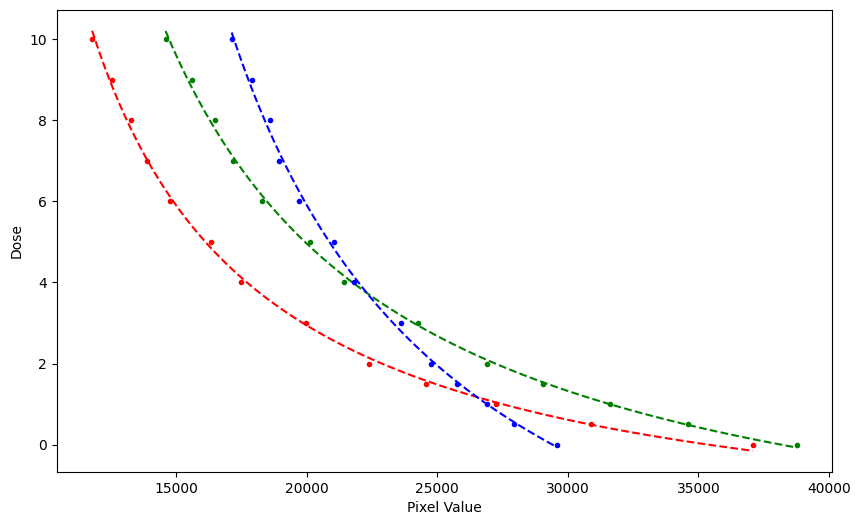

In [29]:
def devic(x, a, b, c):
    return a + b / (x - c)

def fit_and_plot(color, rad_list):
    x_data = pixelV_df[f'weighted_{color}'].values
    y_data = np.array(rad_list)

    model = Model(devic)

    params = model.make_params(a=20000., b=1., c=1.)

    result = model.fit(y_data, params, x=x_data)

    """print(f"{color} fit report:")
    print(result.fit_report())"""

    a = result.params['a'].value
    b = result.params['b'].value
    c = result.params['c'].value

    curvey = np.linspace(min(x_data), max
    (x_data), 100)
    curvex = devic(curvey, a, b, c)

    plt.plot(x_data, y_data, '.', label=f'{color} data', color = color)
    plt.plot(curvey, curvex, '--', label=f'{color} fit', color = color)
    return result


plt.figure(figsize=(10, 6))
results_pv = []
for color in ['r', 'g', 'b']:
    result = fit_and_plot(color, rad_list)
    results_pv.append(result)

plt.xlabel('Pixel Value')
plt.ylabel('Dose')
plt.show()


# NetOD Analysis

In [30]:
#First we find the most optimal c for the fittinjg curve, then we round up to next integer

def devic(x, a, b, c):
    return (a*x) + (b*x**c)

def optimal_c(color, rad_list):

    x_data = netOD_df[f'{color}'].values
    y_data = np.array(rad_list)
    model = Model(devic)
    params = model.make_params(a=10., b=10., c = 1)
    result = model.fit(y_data, params, x=x_data, model = "leastsq")


    print(f"{color} fit report: ")
    print(result.fit_report())

    a = result.params['a'].value
    b = result.params['b'].value
    c = result.params['c'].value
    
    curvey = np.linspace(min(x_data), max(x_data), 100)
    curvex = devic(curvey, a, b, c)
    print("Most optimal c: ", c)
    return result


optimal_cs = []
for color in ['r', 'g', 'b']:
    result = optimal_c(color, rad_list)
    optimal_cs.append(result)



r fit report: 
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 13
    # variables        = 3
    chi-square         = 0.15745465
    reduced chi-square = 0.01574546
    Akaike info crit   = -51.3763732
    Bayesian info crit = -49.6815252
    R-squared          = 0.99885552
[[Variables]]
    a:  6.59731767 +/- 0.80989867 (12.28%) (init = 10)
    b:  53.8462507 +/- 6.05235404 (11.24%) (init = 10)
    c:  2.95644923 +/- 0.22065683 (7.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = +0.9616
    C(a, c) = +0.9216
    C(a, b) = +0.7859
Most optimal c:  2.956449234002051
g fit report: 
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 13
    # variables        = 3
    chi-square         = 0.19244880
    reduced chi-square = 0.01924488
    Akaike info crit   = -48.7673687
    Bayesian info crit

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument model does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


r fit report: 
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.15804845
    reduced chi-square = 0.01436804
    Akaike info crit   = -53.3274391
    Bayesian info crit = -52.1975404
    R-squared          = 0.99885120
[[Variables]]
    a:  6.74179083 +/- 0.29636178 (4.40%) (init = 10)
    b:  55.0158226 +/- 1.62054606 (2.95%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.9403
g fit report: 
[[Model]]
    Model(devic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 0.20919385
    reduced chi-square = 0.01901762
    Akaike info crit   = -49.6827628
    Bayesian info crit = -48.5528641
    R-squared          = 0.99847944
[[Variables]]
    a:  11.2543107 +/- 0.40489851 (3.60%) (init = 10)
    b:  71.098516

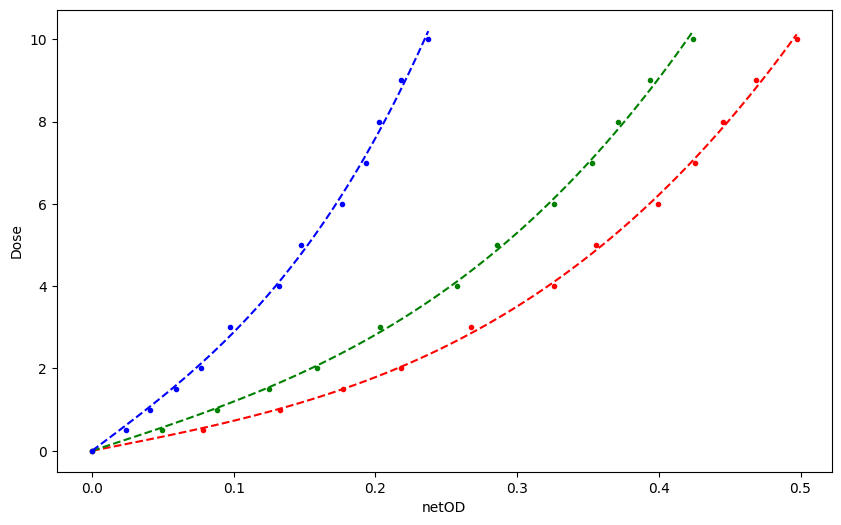

In [31]:
def round_up(n, decimals=0):
    """Esta función regresa el valor redondeado hacia arriba. """
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier

exp = round_up(optimal_cs[0].params['c'].value)
def devic(x, a, b):
    return (a*x) + (b*x**exp)

def fit_and_plot(color, rad_list):

    x_data = netOD_df[f'{color}'].values
    y_data = np.array(rad_list)
    model = Model(devic)
    params = model.make_params(a=10., b=10.)
    result = model.fit(y_data, params, x=x_data, model = "leastsq")


    print(f"{color} fit report: ")
    print(result.fit_report())

    a = result.params['a'].value
    b = result.params['b'].value
    
    curvey = np.linspace(min(x_data), max(x_data), 100)
    curvex = devic(curvey, a, b)

    plt.plot(x_data, y_data, '.', label=f'{color} data', color = color)
    plt.plot(curvey, curvex, '--', label=f'{color} fit', color = color)

    return result


plt.figure(figsize=(10, 6))
results_netOD = []
for color in ['r', 'g', 'b']:
    result = fit_and_plot(color, rad_list)
    results_netOD.append(result)

plt.xlabel('netOD')
plt.ylabel('Dose')
plt.show()


Uncertainty analysis one channel

Fitting parameters:
[ 6.66657059 55.07762966]
Residuals sum of squares:
0.14906038610303582
Dfit: [-0.          0.55602105  1.02027079  1.50368641  2.0348994   2.85680017
  4.09965799  4.86352495  6.18548093  7.10312238  7.86823975  8.84975778
 10.10121924]
[4.22850339 3.89383976 3.57186223 3.29319012 2.99454293 2.73509377
 2.64162676 2.5442636  2.50564788 2.48461572 2.4676604  2.45683248]
[2.10627577 1.52855485 1.31029389 1.29146922 1.16315144 1.41112271
 1.28260746 1.22241945 1.18255606 1.08677343 1.15758078 1.13912787]
[4.72404896 4.18311702 3.80461166 3.53737105 3.21250815 3.0776623
 2.93654113 2.82269138 2.77068766 2.71189818 2.72568177 2.70806908]
a = 6.667 ± 0.296
b = 55.078 ± 1.621
[ 2.46828482 13.46115972]


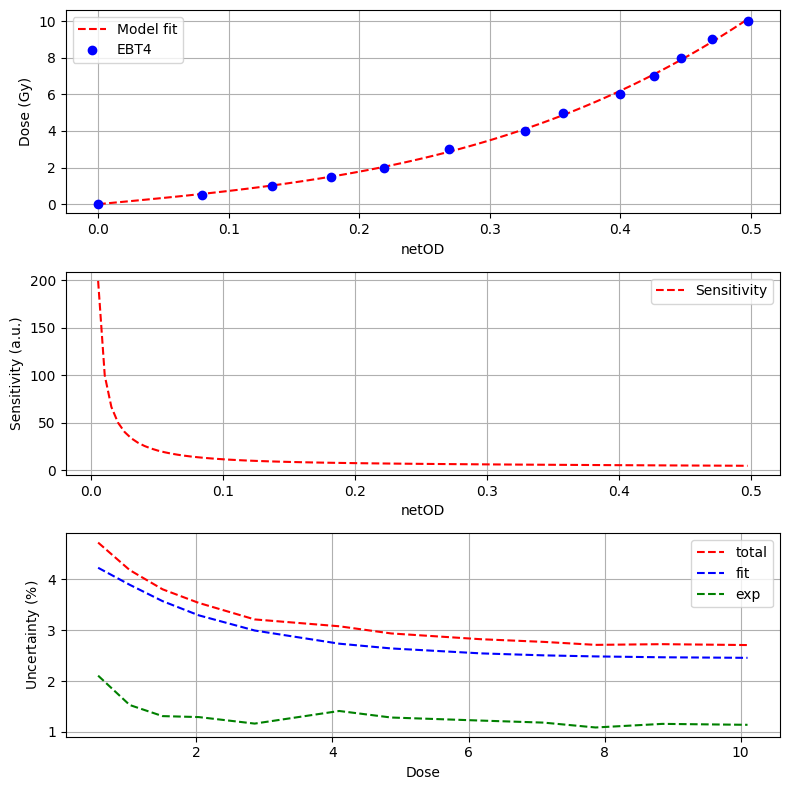

In [32]:
def devic(x, a, b):
    return (a*x) + (b*x**exp)

dosis = np.array(rad_list)
sigma = np.array(netOD_df['std_r'])
netOD = np.array(netOD_df['weighted_r'])

popt, pcov = curve_fit(devic, netOD, dosis, p0=(100., 10.), absolute_sigma=True)

print("Fitting parameters:")
print(popt)
residuals = dosis - devic(netOD, *popt)
fres = sum(residuals**2)
print("Residuals sum of squares:")
print(fres)

curvex = np.linspace(min(netOD), max(netOD), 100)
curvey = devic(curvex, *popt)

dy = np.gradient(curvey[1:])
dx = np.gradient(curvex[1:])

d = (1 / curvey[1:]) * dy / dx

fig, ax = plt.subplots(3, 1, figsize=(8, 8)) 
ax[0].plot(curvex, curvey, '--r', label='Model fit')
ax[0].plot(netOD, dosis, 'ob', label='EBT4')
ax[1].plot(curvex[1:], d, '--r', label='Sensitivity')

ax[0].set_xlabel('netOD')
ax[0].set_ylabel('Dose (Gy)')
ax[1].set_xlabel('netOD')
ax[1].set_ylabel('Sensitivity (a.u.)')
ax[2].set_xlabel('Dose')
ax[2].set_ylabel('Uncertainty ($\%$)')

a, b = popt
a_std_dev, b_std_dev = results_netOD[0].params['a'].stderr, results_netOD[0].params['b'].stderr


dfit = devic(netOD, *popt)
print("Dfit:", dfit)

ufit = np.sqrt((netOD[1:] * a_std_dev)**2  + netOD[1:]**(exp * 2) * b_std_dev**2) / dfit[1:] * 100
uexp = np.sqrt((a + exp * b * netOD[1:]**(exp-1))**2 * sigma[1:]**2) / dfit[1:] * 100
utotal = np.sqrt(ufit**2 + uexp**2)

ax[2].plot(dfit[1:], utotal, '--r', label='total')
ax[2].plot(dfit[1:], ufit, '--b', label='fit')
ax[2].plot(dfit[1:], uexp, '--g', label='exp')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

print(ufit)
print(uexp)
print(utotal)

print(f"a = {a:.3f} ± {a_std_dev:.3f}")
print(f"b = {b:.3f} ± {b_std_dev:.3f}")

ux = np.sqrt(np.diag(pcov))
print(ux)

plt.tight_layout()
plt.show()


Uncertainty analysis multiple channels

Fitting parameters for red:
[ 6.66657059 55.07762966]
Residuals sum of squares for red:
0.14906038610303582
Dfit for red: [-0.          0.55602105  1.02027079  1.50368641  2.0348994   2.85680017
  4.09965799  4.86352495  6.18548093  7.10312238  7.86823975  8.84975778
 10.10121924]
Uncertainties for red:
[4.22850339 3.89383976 3.57186223 3.29319012 2.99454293 2.73509377
 2.64162676 2.5442636  2.50564788 2.48461572 2.4676604  2.45683248]
[2.10627577 1.52855485 1.31029389 1.29146922 1.16315144 1.41112271
 1.28260746 1.22241945 1.18255606 1.08677343 1.15758078 1.13912787]
[4.72404896 4.18311702 3.80461166 3.53737105 3.21250815 3.0776623
 2.93654113 2.82269138 2.77068766 2.71189818 2.72568177 2.70806908]
a = 6.667 ± 0.296
b = 55.078 ± 1.621
[ 2.46828482 13.46115972]
Fitting parameters for green:
[11.26795546 70.99717535]
Residuals sum of squares for green:
0.19815875025457008
Dfit for green: [-0.          0.56260827  1.04635489  1.55371568  2.06850454  2.89592358
  4.10712352  4.83406232  6

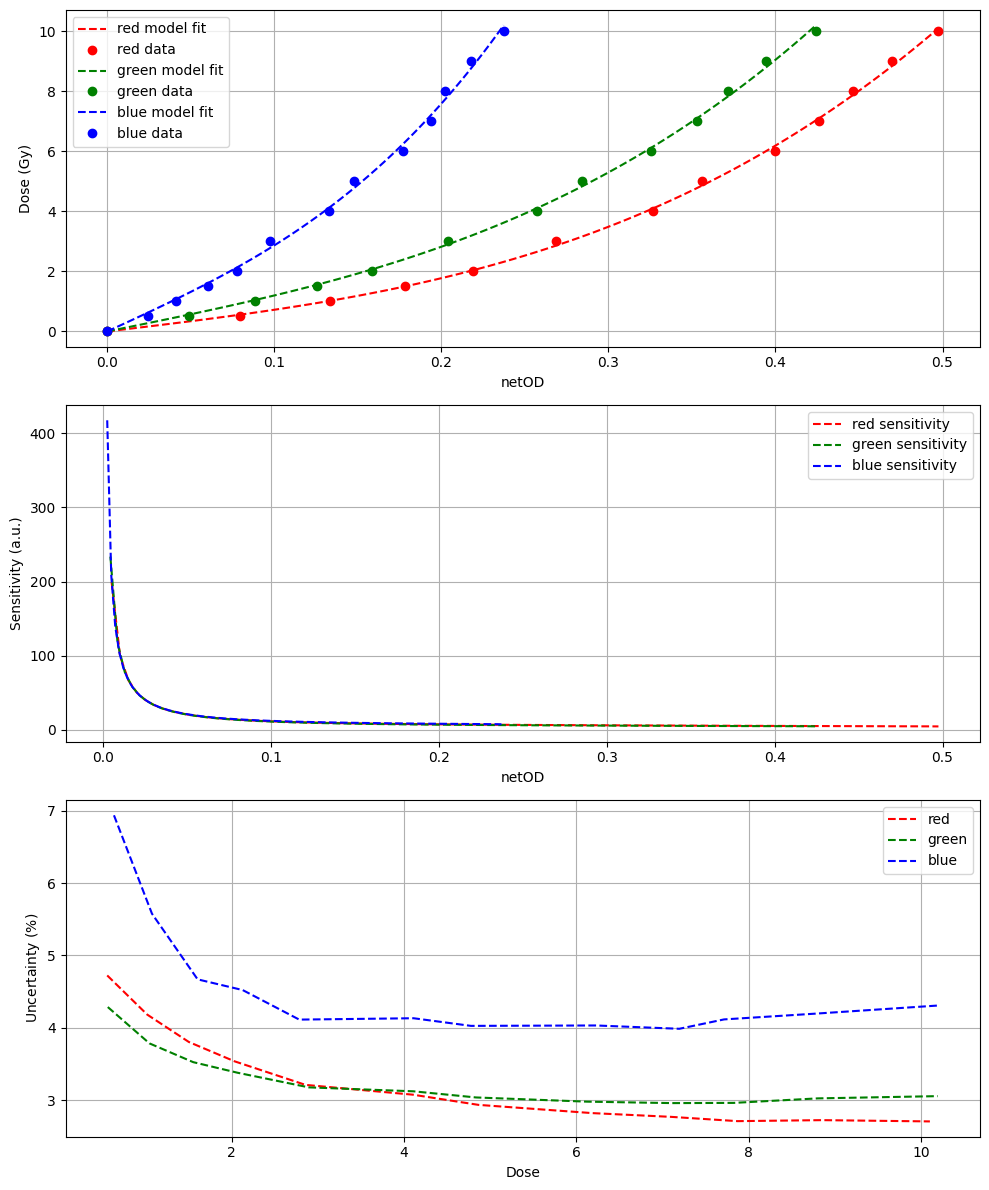

In [33]:
def devic(x, a, b):
    return (a * x) + (b * x**exp)

dosis = np.array(rad_list)

colors = ['r', 'g', 'b']
color_labels = {'r': 'red', 'g': 'green', 'b': 'blue'}

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

for i, color in enumerate(colors):
    netOD = np.array(netOD_df[f'weighted_{color}'])
    sigma = np.array(netOD_df[f'std_{color}'])

    popt, pcov = curve_fit(devic, netOD, dosis, p0=(100., 10.), absolute_sigma=True)

    print(f"Fitting parameters for {color_labels[color]}:")
    print(popt)
    residuals = dosis - devic(netOD, *popt)
    fres = sum(residuals**2)
    print(f"Residuals sum of squares for {color_labels[color]}:")
    print(fres)

    curvex = np.linspace(min(netOD), max(netOD), 100)
    curvey = devic(curvex, *popt)

    dy = np.gradient(curvey[1:])
    dx = np.gradient(curvex[1:])

    d = (1 / curvey[1:]) * dy / dx

    ax[0].plot(curvex, curvey, '--', label=f'{color_labels[color]} model fit', color=color)
    ax[0].plot(netOD, dosis, 'o', label=f'{color_labels[color]} data', color=color)
    ax[1].plot(curvex[1:], d, '--', label=f'{color_labels[color]} sensitivity', color=color)

    a, b = popt
    a_std_dev = results_netOD[i].params['a'].stderr
    b_std_dev = results_netOD[i].params['b'].stderr

    dfit = devic(netOD, *popt)
    print(f"Dfit for {color_labels[color]}:", dfit)

    ufit = np.sqrt((netOD[1:] * a_std_dev)**2  + netOD[1:]**(exp * 2) * b_std_dev**2) / dfit[1:] * 100
    uexp = np.sqrt((a + exp * b * netOD[1:]**(exp-1))**2 * sigma[1:]**2) / dfit[1:] * 100
    utotal = np.sqrt(ufit**2 + uexp**2)

    ax[2].plot(dfit[1:], utotal, '--', label=f'{color_labels[color]}', color=color)
    #ax[2].plot(dfit, ufit, '-', label=f'{color_labels[color]} ', color=color)
    #ax[2].plot(dfit, uexp, ':', label=f'{color_labels[color]}', color=color)

    print(f"Uncertainties for {color_labels[color]}:")
    print(ufit)
    print(uexp)
    print(utotal)
    print(f"a = {a:.3f} ± {a_std_dev:.3f}")
    print(f"b = {b:.3f} ± {b_std_dev:.3f}")

    ux = np.sqrt(np.diag(pcov))
    print(ux)
    print("===================================================================")

ax[0].set_xlabel('netOD')
ax[0].set_ylabel('Dose (Gy)')
ax[1].set_xlabel('netOD')
ax[1].set_ylabel('Sensitivity (a.u.)')
ax[2].set_xlabel('Dose')
ax[2].set_ylabel('Uncertainty ($\%$)')

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#Checkpoint